# Introduction

Generative Adversarial Networks, or GANs are deep learning architecture that consist of two neural networks ( a generator model and a discriminator model) competing against each other. 

This project aims to generate images in the style of Monet, using a generator model and a discriminator model from GAN model, specifically CycleGAN architecture. The two models will work against each other to accurately clsasify the real vs. generated images. The discriminator takes "true" and "generated" data and try to discriminate them.

This project follows Amy Jang's tutorial with modifications for the generator model and discriminator model.


In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import numpy as np

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

autotune = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

import keras,os
os.system('pip install visualkeras')
import visualkeras

D0617 19:27:12.231105939   14182 config.cc:119]                        gRPC EXPERIMENT tcp_frame_size_tuning               OFF (default:OFF)
D0617 19:27:12.231136599   14182 config.cc:119]                        gRPC EXPERIMENT tcp_rcv_lowat                       OFF (default:OFF)
D0617 19:27:12.231140187   14182 config.cc:119]                        gRPC EXPERIMENT peer_state_based_framing            OFF (default:OFF)
D0617 19:27:12.231143042   14182 config.cc:119]                        gRPC EXPERIMENT flow_control_fixes                  ON  (default:ON)
D0617 19:27:12.231145577   14182 config.cc:119]                        gRPC EXPERIMENT memory_pressure_controller          OFF (default:OFF)
D0617 19:27:12.231148132   14182 config.cc:119]                        gRPC EXPERIMENT unconstrained_max_quota_buffer_size OFF (default:OFF)
D0617 19:27:12.231150843   14182 config.cc:119]                        gRPC EXPERIMENT new_hpack_huffman_decoder           ON  (default:ON)
D0617 19:27:12.

Device: 
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


Number of replicas: 8
2.12.0



[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [2]:
folder = KaggleDatasets().get_gcs_path('gan-getting-started')

get_gcs_path is not required on TPU VMs which can directly use Kaggle datasets, using path: /kaggle/input/gan-getting-started


# Exploratory Data Analysis 

**Count files in each folder**

In [3]:
monet_jpg = tf.io.gfile.glob(str(folder + '/monet_jpg/*.jpg'))
print('Monet JPG Files:', len(monet_jpg))

monet_tfrec = tf.io.gfile.glob(str(folder + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(monet_tfrec))

photo_jpg = tf.io.gfile.glob(str(folder + '/photo_jpg/*.jpg'))
print('Photo JPG Files:', len(photo_jpg))

photo_tfrec = tf.io.gfile.glob(str(folder + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(photo_tfrec))

Monet JPG Files: 300
Monet TFRecord Files: 5
Photo JPG Files: 7038
Photo TFRecord Files: 20


In [4]:
IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

In [5]:
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=autotune)
    return dataset

In [6]:
monet_data = load_dataset(monet_tfrec, labeled=True).batch(1)
photo_data = load_dataset(photo_tfrec, labeled=True).batch(1)

**Image dimensions**

In [ ]:
def image_dim(data):
    sample_image = next(iter(data))
    image_shape = sample_image.shape

    return image_shape

print(f'Monet shape: {image_dim(monet_data)}')
print(f'Photo shape: {image_dim(photo_data)}')

**Visualize the Monet paintings and real pictures.**

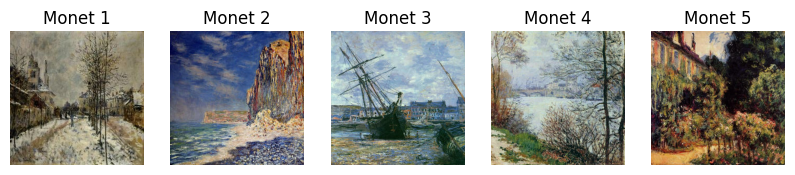

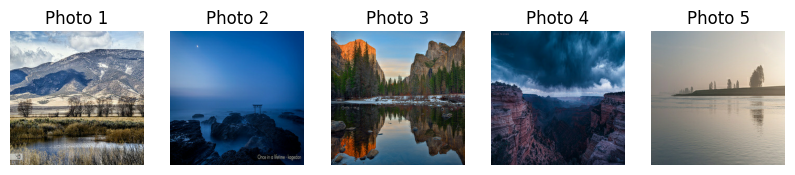

In [8]:
def display_samples(data, title):
    plt.figure(figsize=(10, 10))
    for i, img in enumerate(data.take(5)):
        plt.subplot(1, 5, i+1)
        plt.title(f'{title} {i+1}')
        plt.imshow(img[0] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

display_samples(monet_data, 'Monet')
display_samples(photo_data, 'Photo')

# Model Architecture

I will be using Instance Normalization instead of Batch Normalization. While batch normalization works on mini-batches of dating training, instance normalization operates on individual instances independently. Instance Normalization is particularly useful in this project as it helps preserving the style and characteristics of each painting, where the goal of this project is to preserve the style of the input painting. The visualization of Instance Normalization and Batch Normalization can be seen as below:

![](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*ETvcPhYH1lCfXndMiKW-jQ.png)
Source: https://medium.com/syncedreview/facebook-ai-proposes-group-normalization-alternative-to-batch-normalization-fb0699bffae7


We will define a downsample and upsample methods; where downsample reduce the width and height of the image by stride, while upsample increases the dimensions of the image.

In [9]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())

    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

In [10]:
def Generator():
    inputs = layers.Input(shape=[256,256,3])

    down_stack = [
        downsample(64, 3, apply_instancenorm=False), 
        downsample(128, 3), 
        downsample(256, 3), 
        downsample(512, 3), 
        downsample(512, 3), 
        downsample(512, 3), 
    ]

    up_stack = [
        upsample(512, 3, apply_dropout=True), 
        upsample(512, 3, apply_dropout=True), 
        upsample(512, 3, apply_dropout=True),
        downsample(256, 3),
        upsample(128, 3), 
        upsample(64, 3),
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 3,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') 

    x = inputs

    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

In [11]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 3, False)(x) 
    down2 = downsample(128, 3)(down1) 
    down3 = downsample(256, 3)(down2) 
    down4 = downsample(512, 3)(down3)  

    zero_pad1 = layers.ZeroPadding2D()(down4) 
    conv = layers.Conv2D(512, 3, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) 

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) 

    last = layers.Conv2D(1, 3, strides=1,
                         kernel_initializer=initializer)(zero_pad2) 

    return tf.keras.Model(inputs=inp, outputs=last)

In [12]:
with strategy.scope():
    monet_generator = Generator() 
    photo_generator = Generator() 

    monet_discriminator = Discriminator() 
    photo_discriminator = Discriminator() 

**Visualize the Generator and Discriminator models**

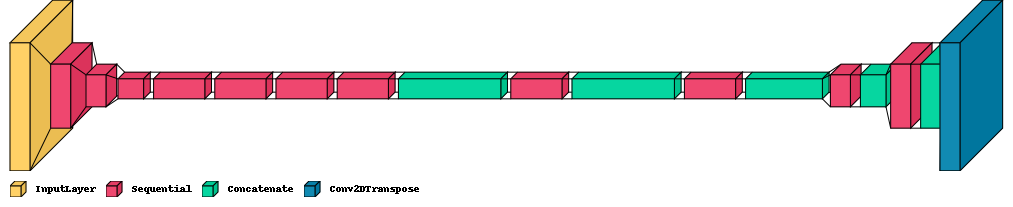

In [13]:
visualkeras.layered_view(Generator(), legend=True, scale_xy=0.5)

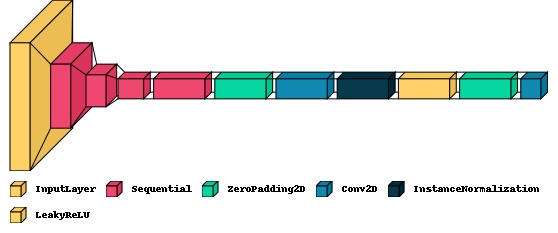

In [14]:
visualkeras.layered_view(Discriminator(), legend=True, scale_xy=0.5)

In [15]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

In [16]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

In [17]:
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

In [18]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

In [19]:
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

In [20]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [21]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

# Results and Analysis

In [33]:
hist = cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_data, photo_data)),
    epochs=30, verbose= 1
)

Epoch 1/30
300/300 [==============================] - 29s 97ms/step - monet_gen_loss: 2.8351 - photo_gen_loss: 2.9586 - monet_disc_loss: 0.6126 - photo_disc_loss: 0.6149
Epoch 2/30
300/300 [==============================] - 29s 96ms/step - monet_gen_loss: 2.8243 - photo_gen_loss: 2.9462 - monet_disc_loss: 0.6096 - photo_disc_loss: 0.6086
Epoch 3/30
300/300 [==============================] - 29s 95ms/step - monet_gen_loss: 2.8191 - photo_gen_loss: 2.9404 - monet_disc_loss: 0.6135 - photo_disc_loss: 0.6107
Epoch 4/30
300/300 [==============================] - 29s 96ms/step - monet_gen_loss: 2.8143 - photo_gen_loss: 2.9347 - monet_disc_loss: 0.6039 - photo_disc_loss: 0.6033
Epoch 5/30
300/300 [==============================] - 29s 96ms/step - monet_gen_loss: 2.8084 - photo_gen_loss: 2.9325 - monet_disc_loss: 0.6099 - photo_disc_loss: 0.6037
Epoch 6/30
300/300 [==============================] - 29s 95ms/step - monet_gen_loss: 2.8102 - photo_gen_loss: 2.9128 - monet_disc_loss: 0.6050 - phot

**Visualize the predictions**

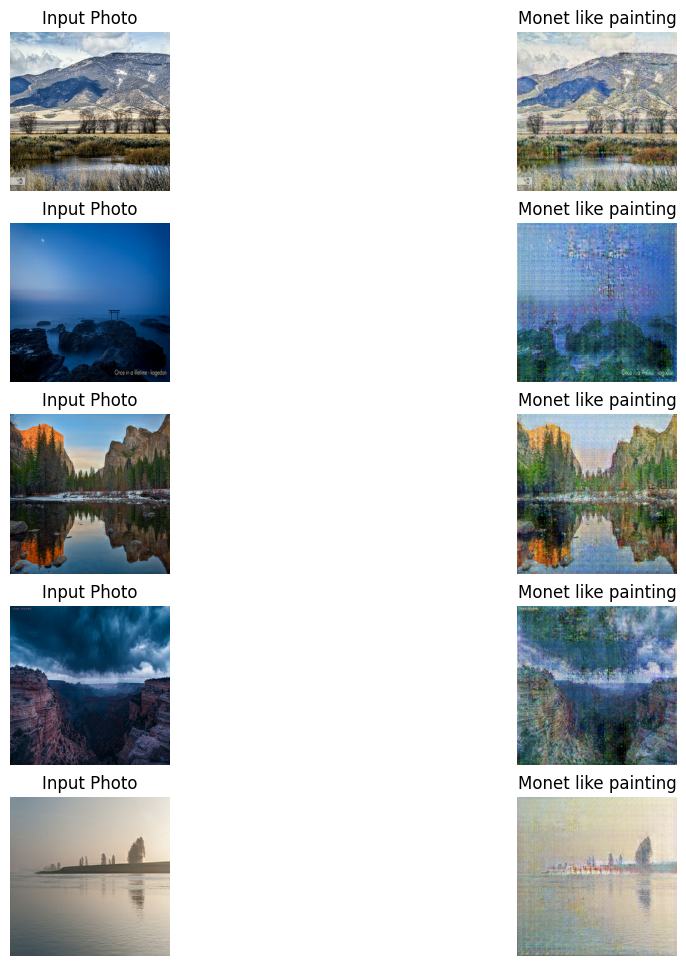

In [34]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_data.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet like painting")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

In [41]:
import PIL
! mkdir ../images

mkdir: cannot create directory ‘../images’: File exists


In [42]:
i = 1
for img in photo_data:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1

In [43]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

'/kaggle/working/images.zip'

# Conclusion

The submission score is 59.339 which is 51th on the leaderboard. This project has provided insights into CycleGAN model, as well as buiding the Generator and Discriminator models. After training Monet style photo with Gan model, we can see the results have demonstrated its ability of image-to-image translation tasks without paired training data.
The predicted images demonstrate the model's ability to exhibit creativity and produce synthetic images that closely resemble Monet's unique style. By leveraging the learned knowledge from the training data, the Generator was able to produce painting that would have been painted my Monet.